#### Assessing Marketplace Accessibility: Isochrones for Marketplaces and Supermarkets in Quezon City

Janssens & Sezer (2013). Marketplaces as an Urban Development Strategy (Editorial). Built Environment, 39: 10.2148/benv.39.2.169

Markets act as:
- commercial gathering places
- vivid & inclusive public spaces
- nexus of flows of people, goods, and information
- sources of: 
    - fresh & affordable food, 
    - economic opportunities, and 
    - chances to socialize
- engines for sustainable urban growth
- sites to get a pulse of a city
- domains of public discontent & dispute
- sites of congestion, chaos, illegality
- romantic images for late capitalist urban gentrification
- centers of social movements and grassroots initiatives

#### Where the Jobs Are: Analysis of Office Density in Metro Manila

##### Research Questions:
- What is the distribution of office buildings in Metro Manila?
- What are the dominant clusters of office space in Metro Manila?
- How much office space is there per city in Metro Manila?

##### Other indicators:
- Golf Courses (leisure facilities? green spaces?)
- Malls
- Educational (colleges & universities)
- Marketplaces
- LRT stations (isochrones)

Step 0: Set Up Workspace

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import contextily as cx
import numpy as np

In [2]:
import pathlib
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"

Step 1: Data Acquisition

To start, we will first extract all map features with an `office` tag.

In [3]:
# Define place name as Metro Manila
PLACE_NAME = ("Metro Manila, Philippines")

In [4]:
# Extract all offices in Metro Manila
offices = ox.features_from_place(
    PLACE_NAME,
    {
        "building:levels": [str(i) for i in range(10,100)]
    },
    which_result=None
)

In [5]:
type(offices)

geopandas.geodataframe.GeoDataFrame

Next, let us examine the data and see which information is most relevant. We can drop the columns and rows we don't need.

In [6]:
offices.head()

geometry  \
element_type osmid                                                           
node         5163397175                         POINT (121.07877 14.60992)   
way          18585116    POLYGON ((120.98803 14.60846, 120.98819 14.608...   
             22480435    POLYGON ((120.99277 14.56517, 120.99300 14.564...   
             22480452    POLYGON ((120.99222 14.56687, 120.99220 14.566...   
             22648530    POLYGON ((121.02525 14.55591, 121.02491 14.555...   

                        wheelchair amenity addr:city addr:postcode  \
element_type osmid                                                   
node         5163397175        NaN     NaN       NaN           NaN   
way          18585116          yes     NaN    Manila           NaN   
             22480435          NaN     NaN    Manila           NaN   
             22480452          NaN     NaN    Manila           NaN   
             22648530          NaN     NaN    Makati          1226   

                          addr:street  \
element_type osmid                      
node         5163397175           NaN   
way          18585116    Tamayo Drive   
             22480435             NaN   
             22480452             NaN   
             22648530    Ayala Avenue   

                                                               name office  \
element_type osmid                                                           
node         5163397175                                         NaN    NaN   
way          18585116    Buenaventura Garcia Paredes, O.P. Building    NaN   
             22480435                             Henry Sy Sr. Hall    NaN   
             22480452                Enrique M. Razon Sports Center    NaN   
             22648530                          The Peninsula Manila    NaN   

                        phone                                  website  ...  \
element_type osmid                                                      ...   
node         5163397175   NaN                                      NaN  ...   
way          18585116     NaN                                      NaN  ...   
             22480435     NaN                                      NaN  ...   
             22480452     NaN                                      NaN  ...   
             22648530     NaN  https://manila.peninsula.com/en/default  ...   

                        reservation non_existent_levels source:name was:name  \
element_type osmid                                                             
node         5163397175         NaN                 NaN         NaN      NaN   
way          18585116           NaN                 NaN         NaN      NaN   
             22480435           NaN                 NaN         NaN      NaN   
             22480452           NaN                 NaN         NaN      NaN   
             22648530           NaN                 NaN         NaN      NaN   

                        building:units year_of_construction ways type  \
element_type osmid                                                      
node         5163397175            NaN                  NaN  NaN  NaN   
way          18585116              NaN                  NaN  NaN  NaN   
             22480435              NaN                  NaN  NaN  NaN   
             22480452              NaN                  NaN  NaN  NaN   
             22648530              NaN                  NaN  NaN  NaN   

                        heritage construction_year  
element_type osmid                                  
node         5163397175      NaN               NaN  
way          18585116        NaN               NaN  
             22480435        NaN               NaN  
             22480452        NaN               NaN  
             22648530        NaN               NaN  

[5 rows x 159 columns]

In [7]:
offices.shape

(2786, 159)

In [8]:
offices.columns.values

array(['geometry', 'wheelchair', 'amenity', 'addr:city', 'addr:postcode',
       'addr:street', 'name', 'office', 'phone', 'website',
       'addr:province', 'access', 'mapillary', 'parking', 'survey:date',
       'description', 'emergency', 'fee', 'lit', 'opening_hours',
       'smoothness', 'supervised', 'surface', 'addr:housename', 'level',
       'surveillance', 'surveillance:type', 'building', 'building:levels',
       'brand', 'brand:wikidata', 'brand:wikipedia', 'official_name',
       'healthcare', 'shop', 'layer', 'operator', 'brand:instagram',
       'check_date', 'name:en', 'old_name', 'addr:housenumber',
       'payment:cash', 'payment:credit_cards', 'payment:debit_cards',
       'source', 'height', 'note', 'addr:country', 'addr:quarter',
       'frequency', 'wikipedia', 'nodes', 'alt_name', 'architect',
       'short_name', 'smoking', 'building:min_level',
       'building:architecture', 'leisure', 'sport', 'addr:street:corner',
       'tourism', 'wikidata', 'wikimedia_com

In [9]:
offices.reset_index()["element_type"].unique()

array(['node', 'way', 'relation'], dtype=object)

In [10]:
from urban_indicators_scripts import filter_elem_type

offices = filter_elem_type(offices, ["way", "relation"])
offices.head()

,element_type,osmid,geometry,wheelchair,amenity,addr:city,addr:postcode,addr:street,name,office,...,reservation,non_existent_levels,source:name,was:name,building:units,year_of_construction,ways,type,heritage,construction_year
1,way,18585116,"POLYGON ((120.98803 14.60846, 120.98819 14.608...",yes,NaN,Manila,NaN,Tamayo Drive,"Buenaventura Garcia Paredes, O.P. Building",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,way,22480435,"POLYGON ((120.99277 14.56517, 120.99300 14.564...",NaN,NaN,Manila,NaN,NaN,Henry Sy Sr. Hall,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,way,22480452,"POLYGON ((120.99222 14.56687, 120.99220 14.566...",NaN,NaN,Manila,NaN,NaN,Enrique M. Razon Sports Center,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,way,22648530,"POLYGON ((121.02525 14.55591, 121.02491 14.555...",NaN,NaN,Makati,1226,Ayala Avenue,The Peninsula Manila,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,way,22788808,"POLYGON ((121.02140 14.55751, 121.02152 14.557...",NaN,NaN,Makati,NaN,Paseo de Roxas,Philamlife Tower,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Import drop_nan_cols function we created
from urban_indicators_scripts import drop_nan_cols

# Apply imported function
# Parameters: gdf, max % of rows that are NaNs
offices = drop_nan_cols(offices, 0.75)

In [12]:
offices.columns.values

array(['element_type', 'osmid', 'geometry', 'addr:city', 'name',
       'building', 'building:levels', 'height', 'nodes', 'building:part'],
      dtype=object)

In [13]:
offices.isna().sum()

element_type          0
osmid                 0
geometry              0
addr:city          1956
name               1197
building           1098
building:levels       0
height              722
nodes                 0
building:part      1688
dtype: int64

In [14]:
offices.head()

,element_type,osmid,geometry,addr:city,name,building,building:levels,height,nodes,building:part
1,way,18585116,"POLYGON ((120.98803 14.60846, 120.98819 14.608...",Manila,"Buenaventura Garcia Paredes, O.P. Building",school,12,42.9,"[191682731, 191682755, 7119882047, 7119882046,...",NaN
2,way,22480435,"POLYGON ((120.99277 14.56517, 120.99300 14.564...",Manila,Henry Sy Sr. Hall,university,15,53.6,"[241231894, 241231895, 7604181154, 7604181158,...",NaN
3,way,22480452,"POLYGON ((120.99222 14.56687, 120.99220 14.566...",Manila,Enrique M. Razon Sports Center,yes,10,NaN,"[241233167, 7755169338, 7755169340, 4089307758...",NaN
4,way,22648530,"POLYGON ((121.02525 14.55591, 121.02491 14.555...",Makati,The Peninsula Manila,hotel,11,41.1,"[242858533, 319959483, 319959485, 319959486, 5...",NaN
5,way,22788808,"POLYGON ((121.02140 14.55751, 121.02152 14.557...",Makati,Philamlife Tower,commercial,48,200,"[244891956, 244891957, 244891958, 244891959, 2...",NaN


Let us plot the offices on a map to see what we have. But first, let's ensure that the CRS is pseudo-mercator for web-mapping.

In [15]:
epsg = offices.crs.to_epsg()

if epsg != 3857:
    print(f"GDF is in EPSG:{epsg} -- Will reproject to Pseudo-Mercator (EPSG:3857)")
    offices.to_crs("EPSG:3857", inplace=True)

GDF is in EPSG:4326 -- Will reproject to Pseudo-Mercator (EPSG:3857)


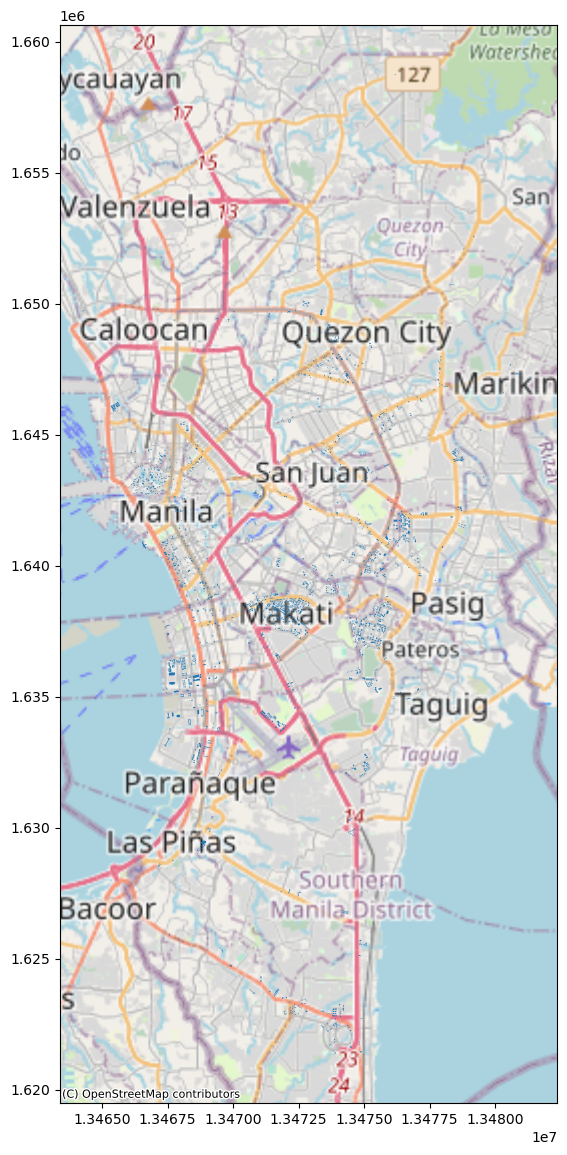

In [16]:
ax = offices.plot(
    figsize=(8,14),
    legend=True
)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)

In [17]:
# Get centroids
offices["centroid"] = offices.centroid

# Get coordinates of office points
coords = offices["centroid"].get_coordinates()
coords

,x,y
1,1.346835e+07,1.644104e+06
2,1.346889e+07,1.639122e+06
3,1.346875e+07,1.639340e+06
4,1.347247e+07,1.637961e+06
5,1.347208e+07,1.638247e+06
...,...,...
2781,1.347305e+07,1.640006e+06
2782,1.347309e+07,1.639898e+06
2783,1.347317e+07,1.639840e+06
2784,1.347310e+07,1.639984e+06


In [18]:
offices["x"] = coords.x
offices["y"] = coords.y

In [19]:
offices.dtypes

element_type         object
osmid                 int64
geometry           geometry
addr:city            object
name                 object
building             object
building:levels      object
height               object
nodes                object
building:part        object
centroid           geometry
x                   float64
y                   float64
dtype: object

In [20]:
offices["area_sqm"] = offices["geometry"].area

offices["total_floor_area"] = offices["building:levels"].astype(int) * offices["area_sqm"]

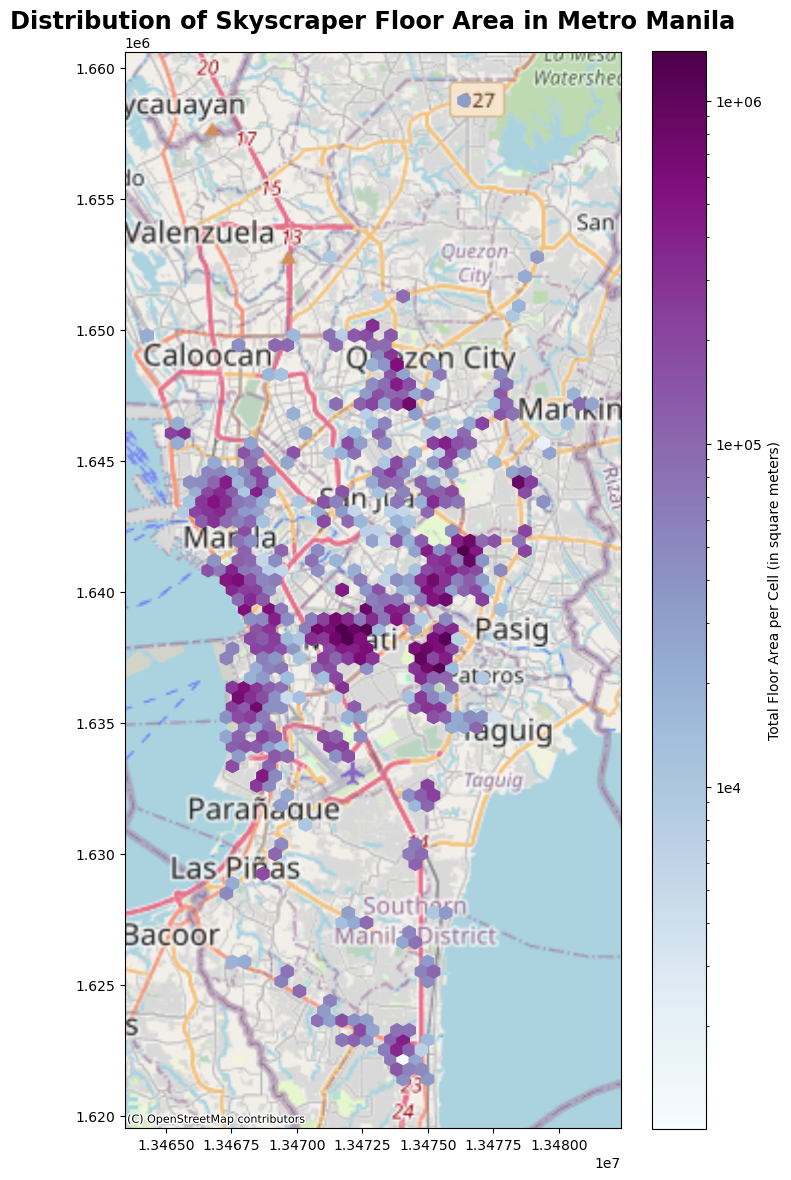

In [21]:
import matplotlib.ticker as ticker

fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(8,14))

hb = ax2.hexbin(
    offices["x"],
    offices["y"],
    # C=offices["building:levels"].astype(int),
    C=offices["total_floor_area"],
    gridsize=(37, 50),
    bins="log",
    # alpha=0.75,
    reduce_C_function=np.sum,
    cmap="BuPu"
)

cb = fig.colorbar(
    hb, 
    ax=ax2, 
    label="Total Floor Area per Cell (in square meters)",
    format=ticker.LogFormatter()
)

plt.title(
    "Distribution of Skyscraper Floor Area in Metro Manila",
    fontsize="xx-large",
    horizontalalignment="center",
    fontweight="heavy"
)

cx.add_basemap(ax2, source=cx.providers.OpenStreetMap.Mapnik)